In [1]:
import os
import pickle

In [2]:
INT_S2_DIR = "_intermediate/stage2_plantdoc"

In [3]:
with open(os.path.join(INT_S2_DIR, "total.pkl"), "rb") as file:
    stage2_results = pickle.load(file)

In [4]:
print(len(stage2_results), stage2_results.keys())

8 dict_keys(['(SAM + YOLOv8) + (InceptionV3)', '(SAM + ResNet) + (InceptionV3)', '(SAM + YOLOv8) + (VGG19)', '(SAM + ResNet) + (VGG19)', '(SAM + YOLOv8) + (AlexNet)', '(SAM + ResNet) + (AlexNet)', '(SAM + YOLOv8) + (ResNet152V2)', '(SAM + ResNet) + (ResNet152V2)'])


In [8]:
results_conv = {}
THRESHOLD = .8
AREA_THRESHOLD = 5_000
MIN_SIDE_THRESHOLD = 100

for name, result in stage2_results.items():
    results_conv[name] = {
        'y_true': [],
        'y_pred': []
    }
    for image_id, data in result.items():
        if len(data['masks']) == 0:
            continue
        ma_index = max(range(len(data['masks'])), key=lambda k: data['masks'][k]['patch'].shape[0] * data['masks'][k]['patch'].shape[1])
        ma_pred = data['predictions'][ma_index]
        results_conv[name]['y_pred'].append(1 if ma_pred > THRESHOLD else 0)
        results_conv[name]['y_true'].append(1 - int(data['healthy']))
        continue 
        for pred, mask in zip(data['predictions'], data['masks']):
            area = mask['patch'].shape[0] * mask['patch'].shape[1]
            if min(mask['patch'].shape[0], mask['patch'].shape[1]) < MIN_SIDE_THRESHOLD:
                continue
            results_conv[name]['y_pred'].append(1 if pred > THRESHOLD else 0)
            results_conv[name]['y_true'].append(1 - int(data['healthy']))
    if len(results_conv[name]['y_true']) == 0:
        print(f"{name} has no results for {image_id}")
        del results_conv[name]

In [ ]:
results_conv

In [9]:
import pickle
with open(os.path.join("_intermediate", "results_conv.pkl"), "wb+") as file:
          pickle.dump(results_conv, file)

In [ ]:
import pickle
with open(os.path.join("_intermediate", "results_conv.pkl"), "rb") as file:
        results_conv = pickle.load(file)

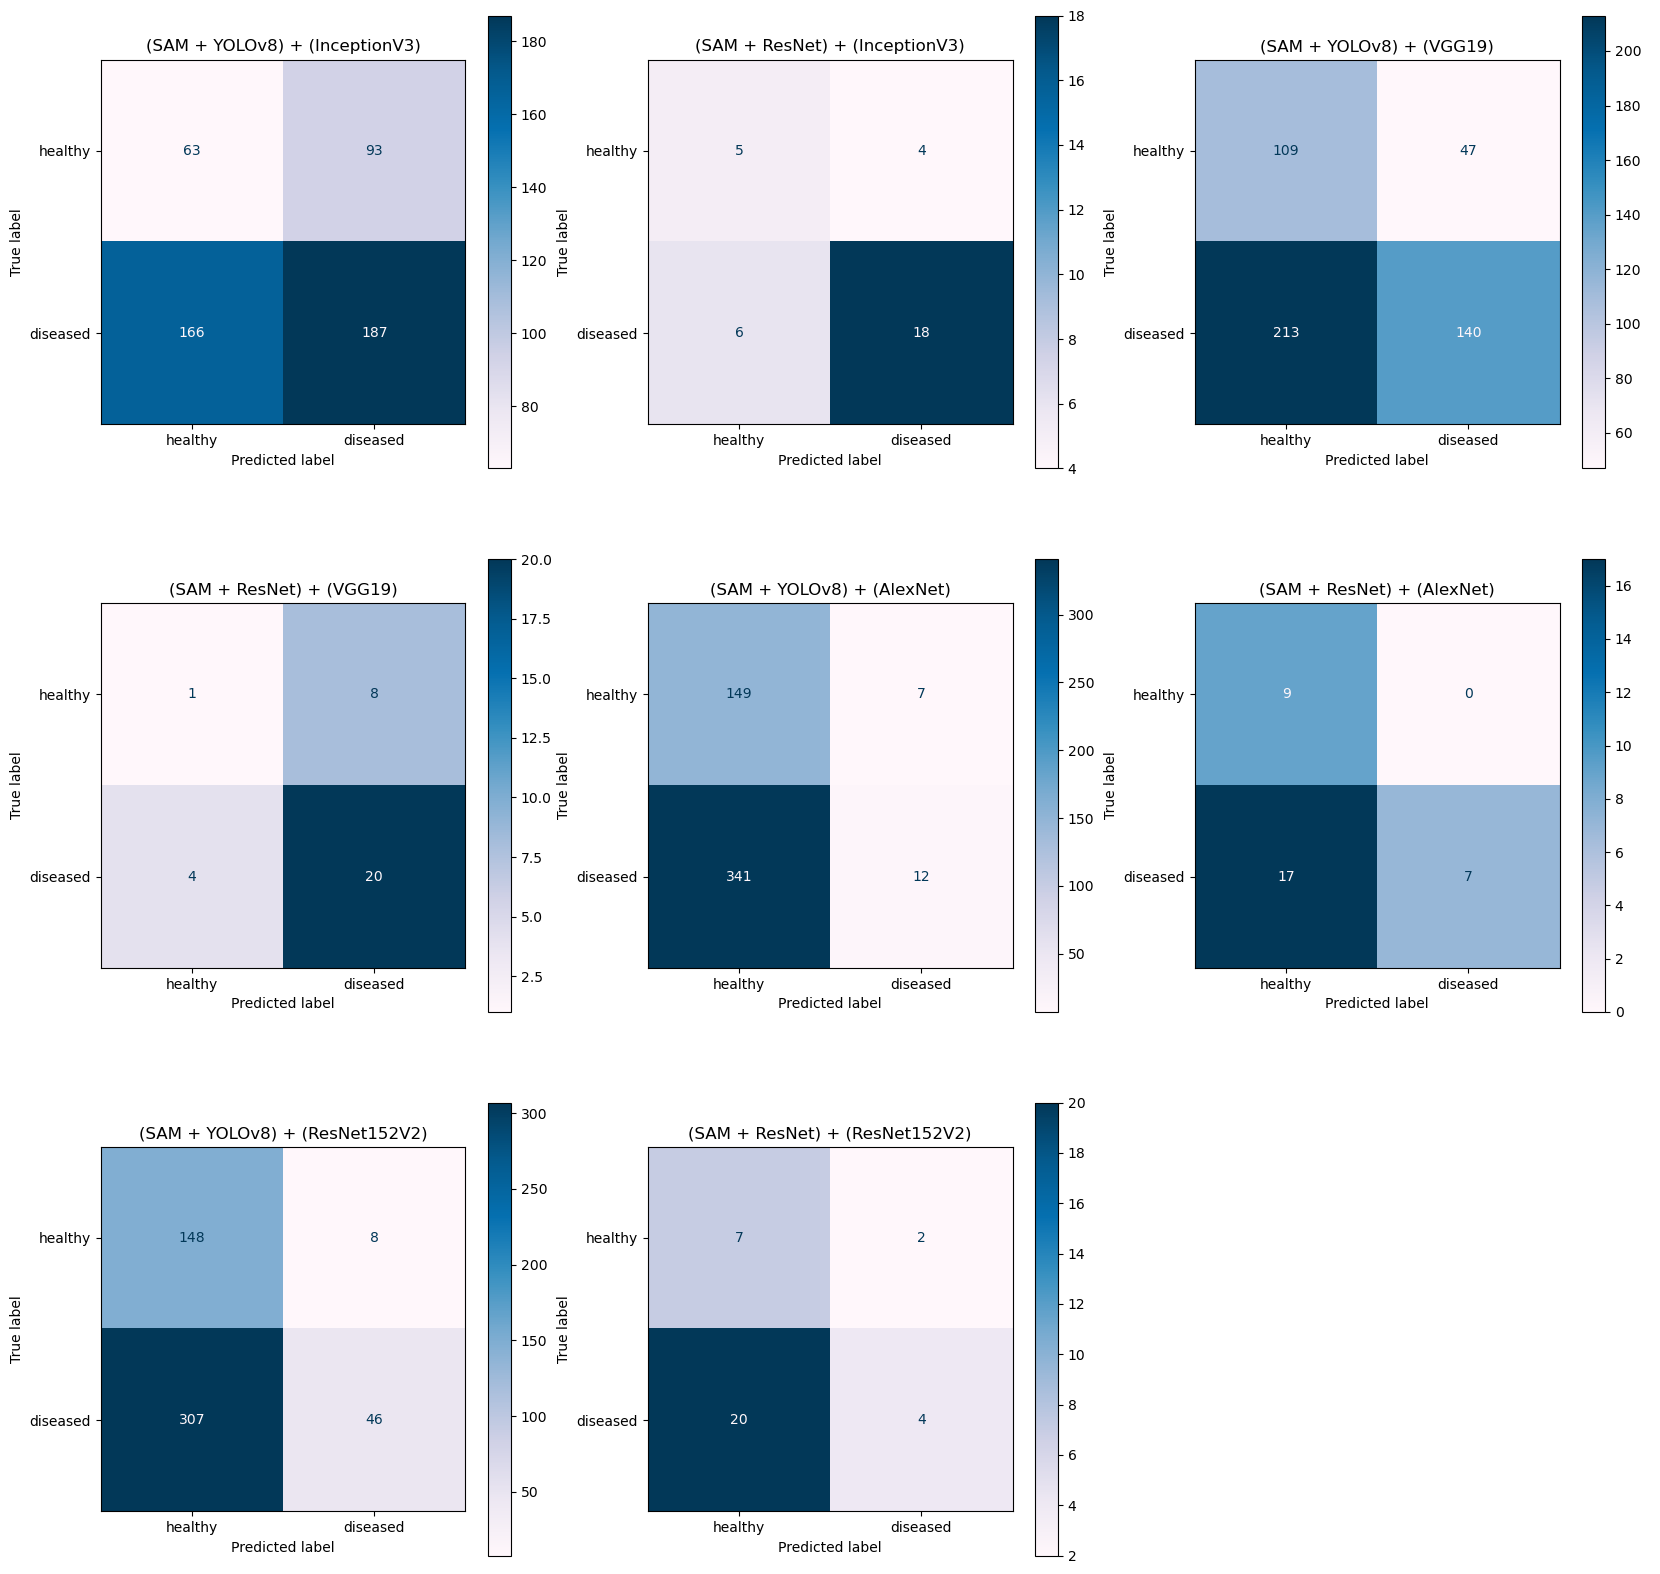

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots((len(results_conv) // 3) + 1, 3, figsize=(20, 20))
axes = axes.flatten()
axes[-1].axis('off')

for ax, (name, data) in zip(axes, results_conv.items()):
    total = len(data['y_true'])
    unique, counts = np.unique(data['y_true'], return_counts=True)
    label_weights = 1 - (counts / total)
    sample_weight = np.array([label_weights[label] for label in data['y_true']])
    disp = ConfusionMatrixDisplay.from_predictions(data['y_true'], data['y_pred'],
                                                   cmap="PuBu", 
                                                   ax=ax, 
                                                   #sample_weight=sample_weight, 
                                                   #normalize='all',
                                                   display_labels=["healthy", 'diseased'])
    disp.ax_.set_title(name)
plt.show()

In [9]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
import pandas as pd

report_df = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'accuracy', 'auc'])

for name, data in results_conv.items():
    total = len(data['y_true'])
    unique, counts = np.unique(data['y_true'], return_counts=True)
    label_weights = 1 - (counts / total)
    sample_weight = np.array([label_weights[label] for label in data['y_true']])
    report = classification_report(data['y_true'], data['y_pred'], sample_weight=sample_weight, output_dict=True)['weighted avg']
    print(report.keys())
    del report['support']
    report['accuracy'] = balanced_accuracy_score(data['y_true'], data['y_pred'], sample_weight=sample_weight)
    report['auc'] = roc_auc_score(data['y_true'], data['y_pred'])
    
    
    report_df.loc[name] = list(report.values())

dict_keys(['precision', 'recall', 'f1-score', 'support'])
dict_keys(['precision', 'recall', 'f1-score', 'support'])
dict_keys(['precision', 'recall', 'f1-score', 'support'])
dict_keys(['precision', 'recall', 'f1-score', 'support'])
dict_keys(['precision', 'recall', 'f1-score', 'support'])
dict_keys(['precision', 'recall', 'f1-score', 'support'])
dict_keys(['precision', 'recall', 'f1-score', 'support'])
dict_keys(['precision', 'recall', 'f1-score', 'support'])


In [ ]:
report_df

In [87]:
report_df.to_latex(float_format="%.4f")

'\\begin{tabular}{lrrrrr}\n\\toprule\n & precision & recall & f1-score & accuracy & auc \\\\\n\\midrule\n(SAM + YOLOv8) + (InceptionV3) & 0.5052 & 0.5035 & 0.4604 & 0.5035 & 0.5035 \\\\\n(SAM + ResNet) + (InceptionV3) & 0.3602 & 0.4000 & 0.3541 & 0.4000 & 0.4000 \\\\\n(SAM + YOLOv8) + (VGG19) & 0.5613 & 0.5556 & 0.5450 & 0.5556 & 0.5556 \\\\\n(SAM + ResNet) + (VGG19) & 0.4233 & 0.4259 & 0.4210 & 0.4259 & 0.4259 \\\\\n(SAM + YOLOv8) + (AlexNet) & 0.5235 & 0.5197 & 0.4994 & 0.5197 & 0.5197 \\\\\n(SAM + ResNet) + (AlexNet) & 0.4355 & 0.4519 & 0.4147 & 0.4519 & 0.4519 \\\\\n(SAM + YOLOv8) + (ResNet152V2) & 0.5463 & 0.5257 & 0.4662 & 0.5257 & 0.5257 \\\\\n(SAM + ResNet) + (ResNet152V2) & 0.6062 & 0.5407 & 0.4571 & 0.5407 & 0.5407 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [88]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#scaled_df = pd.DataFrame(scaler.fit_transform(report_df), columns=report_df.columns, index=report_df.index)

# Step 4: Melt the DataFrame for seaborn
scaled_df_melted = report_df.reset_index().melt(id_vars='index', 
                                                var_name='Metric', 
                                                value_name='Scaled Value')
scaled_df_melted.rename(columns={'index': 'DataFrame'}, inplace=True)

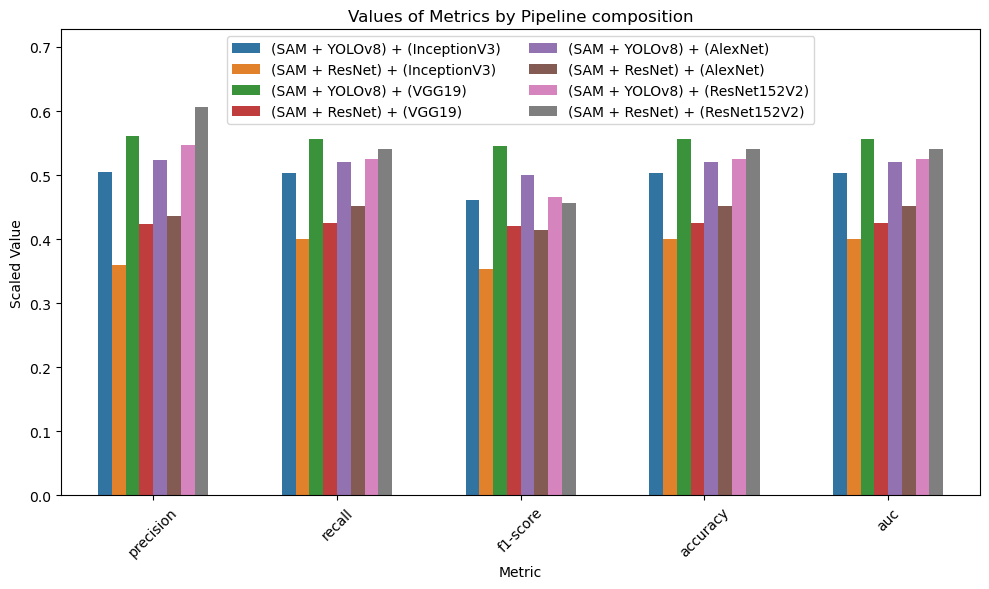

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Scaled Value', hue='DataFrame', data=scaled_df_melted, dodge=True, width=0.6, legend='brief')
ax.margins(y=.2)
ax.legend(ncol=2, loc='upper center')
plt.title('Values of Metrics by Pipeline composition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()